# Project Setup & Data Load

In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv(r"/kaggle/input/e-commerce-churn-dataset-rees46/rees46_customer_model.csv")

# Quick check
print(df.shape)
print(df.columns[:20])

print(df.head())

(112610, 276)
Index(['row_id', 'user_id', 'length_mean', 'start_year_mean',
       'start_yearday_mean', 'start_month_mean', 'start_monthday_mean',
       'start_week_mean', 'start_weekday_mean', 'start_isweekend_mean',
       'start_hour_mean', 'haspurchase_mean', 'click_count_mean',
       'view_count_mean', 'cart_count_mean', 'purchase_count_mean',
       'time_to_click_mean', 'time_to_view_mean', 'time_to_cart_mean',
       'time_to_purchase_mean'],
      dtype='object')
   row_id    user_id   length_mean  start_year_mean  start_yearday_mean  \
0      31  522576412  10133.678750        2019.3250           241.65000   
1      53  551695186      5.359195        2019.3620           222.05173   
2      65  561472000      4.885714        2019.0000           297.54285   
3      85  585643355   4175.082759        2019.8966           106.00000   
4     133  520792937      3.325601        2019.3196           212.86598   

   start_month_mean  start_monthday_mean  start_week_mean  start_week

Industry Tip: Always start by understanding the dataset size, feature types, and target distribution.

# Data Cleaning / Preparation

In [2]:
# Drop ID columns
df = df.drop(['row_id','user_id'], axis=1)

# Check missing
print(df.isnull().sum().sort_values(ascending=False))

# Fill or drop missing if necessary
df = df.fillna(0)  # or domain-specific imputation

length_mean               0
session_number_cv         0
session_count_ratio       0
purchase_recency_cv       0
inter_purchase_time_cv    0
                         ..
start_monthday_max        0
start_week_max            0
start_weekday_max         0
start_isweekend_max       0
target_actual_profit      0
Length: 274, dtype: int64


Industry Tip: In churn, missing values often carry meaning (e.g., no purchase activity = 0).

# Exploratory Data Analysis (EDA)

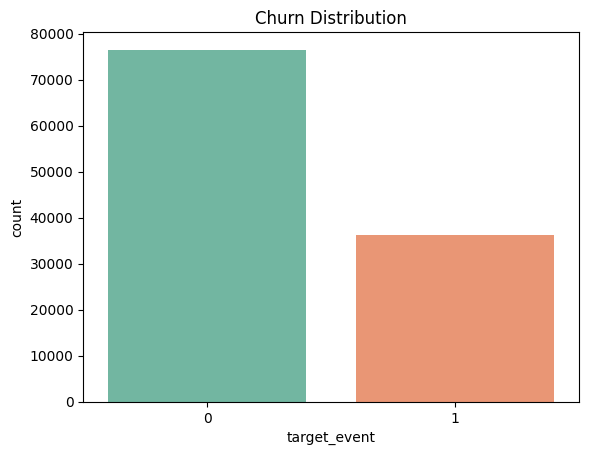

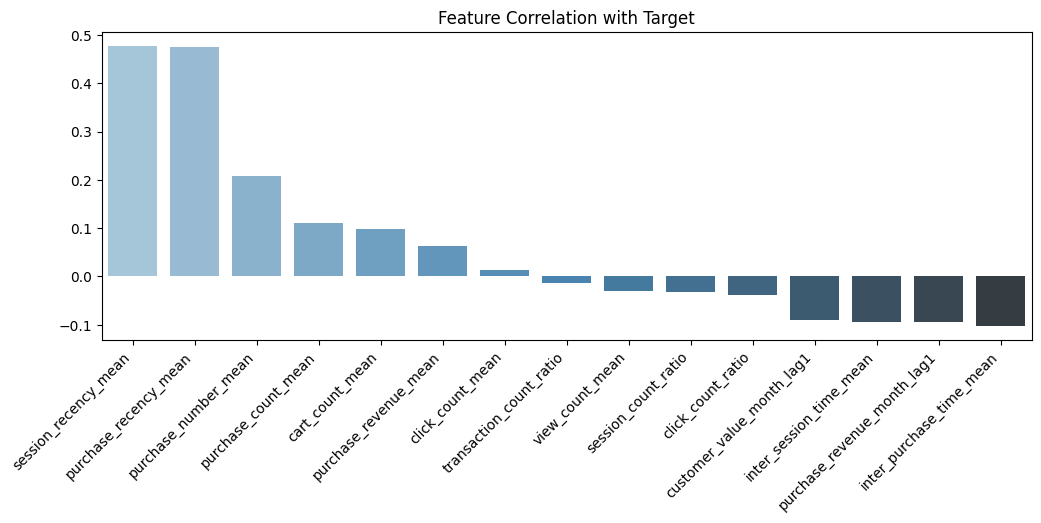

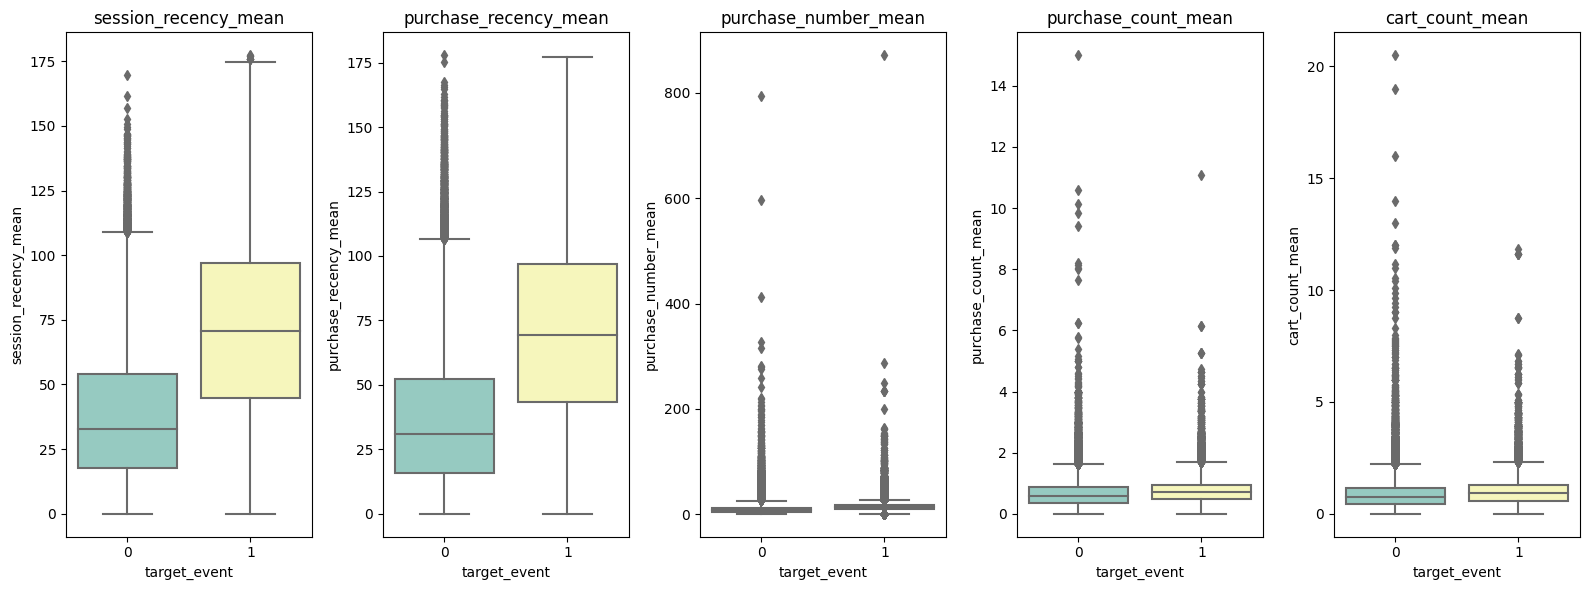

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Selected features for EDA
# -------------------------

eda_features = [
  'click_count_mean', 'view_count_mean', 'cart_count_mean',
    'purchase_count_mean', 'session_recency_mean', 'purchase_revenue_mean',
    'inter_session_time_mean', 'purchase_number_mean', 'inter_purchase_time_mean',
    'purchase_recency_mean', 'session_count_ratio', 'click_count_ratio',
    'transaction_count_ratio', 'customer_value_month_lag1', 'purchase_revenue_month_lag1'
]


# Keep only features that exist
eda_features = [f for f in eda_features if f in df.columns]

# -------------------------
# 1. Churn distribution
# -------------------------
sns.countplot(x='target_event', data=df, palette="Set2")
plt.title("Churn Distribution")
plt.show()

# -------------------------
# 2. Correlation with target
# -------------------------
target_corr = df[eda_features + ['target_event']].corr()['target_event'].sort_values(ascending=False)
plt.figure(figsize=(12,4))
sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:], palette="Blues_d")
plt.xticks(rotation=45, ha='right')
plt.title("Feature Correlation with Target")
plt.show()

# -------------------------
# 3. Boxplots for top 5 correlated features
# -------------------------
top5_features = target_corr.index[1:6]  # Skip target itself

plt.figure(figsize=(16,6))
for i, col in enumerate(top5_features):
    plt.subplot(1, 5, i+1)
    sns.boxplot(x='target_event', y=col, data=df, palette="Set3")
    plt.title(col)
plt.tight_layout()
plt.show()

Insight Angle: Show which behaviors lead to churn — e.g., low cart addition or high session recency.

# Feature Selection

In [4]:
# Target variable
y = df['target_event']

# Features to drop (identifiers / leakage)
drop_features = [
    'row_id',
    'user_id',
    'haspurchase_mean',        # direct leakage
    'time_to_purchase_mean'    # strong leakage
]

# Final selected feature set (from CatBoost/XGBoost/LightGBM)
# ----------------------
features = [
   'purchase_number_max', 'inter_session_time_mean', 'session_count_ratio',
    'customer_value_month_lag1', 'purchase_number_sum', 'inter_purchase_time_mean',
    'purchase_number_mean', 'purchase_recency_mean', 'session_recency_max',
    'purchase_revenue_month_lag1', 'session_recency_mean', 'customer_value_month_lag2',
    'customer_value_month_lag3', 'purchase_revenue_month_lag2', 'purchase_revenue_sum'
]

# Final dataset
X = df[features]

Industry Tip: Avoid including too many redundant features — keeps model interpretable.

# Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Model Selection & Training

# CatBoost

In [6]:
# ---------- CatBoost ----------
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=1115,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=1000)

0:	test: 0.8630196	best: 0.8630196 (0)	total: 87ms	remaining: 1m 36s
100:	test: 0.8859409	best: 0.8859409 (100)	total: 2.23s	remaining: 22.3s
200:	test: 0.8906560	best: 0.8906560 (200)	total: 4.32s	remaining: 19.6s
300:	test: 0.8937739	best: 0.8937739 (300)	total: 6.55s	remaining: 17.7s
400:	test: 0.8957616	best: 0.8957616 (400)	total: 8.7s	remaining: 15.5s
500:	test: 0.8972781	best: 0.8972781 (500)	total: 10.8s	remaining: 13.2s
600:	test: 0.8982591	best: 0.8982640 (597)	total: 12.9s	remaining: 11.1s
700:	test: 0.8987990	best: 0.8988090 (698)	total: 15s	remaining: 8.89s
800:	test: 0.8993485	best: 0.8993706 (795)	total: 17.1s	remaining: 6.71s
900:	test: 0.8994898	best: 0.8995014 (853)	total: 19.3s	remaining: 4.58s
1000:	test: 0.8996898	best: 0.8997044 (997)	total: 21.5s	remaining: 2.44s
1100:	test: 0.8998527	best: 0.8998549 (1099)	total: 23.6s	remaining: 300ms
1114:	test: 0.8998853	best: 0.8998870 (1110)	total: 23.9s	remaining: 0us

bestTest = 0.8998870169
bestIteration = 1110

Shrink m

# XGBoost

In [7]:

# ---------- XGBoost ----------
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight


xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

[0]	validation_0-logloss:0.60606
[100]	validation_0-logloss:0.36273
[200]	validation_0-logloss:0.35436
[300]	validation_0-logloss:0.35190
[400]	validation_0-logloss:0.35093
[500]	validation_0-logloss:0.35038
[600]	validation_0-logloss:0.35050
[700]	validation_0-logloss:0.35076
[800]	validation_0-logloss:0.35139
[900]	validation_0-logloss:0.35195
[1000]	validation_0-logloss:0.35258
[1100]	validation_0-logloss:0.35328
[1200]	validation_0-logloss:0.35383
[1300]	validation_0-logloss:0.35459
[1400]	validation_0-logloss:0.35556
[1500]	validation_0-logloss:0.35649
[1600]	validation_0-logloss:0.35730
[1700]	validation_0-logloss:0.35823
[1800]	validation_0-logloss:0.35907
[1900]	validation_0-logloss:0.36001
[1999]	validation_0-logloss:0.36093


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

# LightGBM

In [8]:
# ---------- LightGBM ----------
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

lgb_model = lgb.LGBMClassifier(
    n_estimators=530,
    learning_rate=0.05,
    max_depth=6,
    objective='binary',
    n_jobs=-1,
    random_state=42,
)
# Fit the model correctly
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

# Generate probabilities
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 28904, number of negative: 61184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3813
[LightGBM] [Info] Number of data points in the train set: 90088, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320842 -> initscore=-0.749906
[LightGBM] [Info] Start training from score -0.749906
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.892052	valid_0's binary_logloss: 0.364515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Industry Tip: Use early stopping to prevent overfitting and speed up training.

# Feature Importance


--- CatBoost Feature Importance ---
                        feature  importance
1       inter_session_time_mean   14.386750
0           purchase_number_max   13.729023
2           session_count_ratio   11.251795
6          purchase_number_mean    8.821139
3     customer_value_month_lag1    7.652902
4           purchase_number_sum    6.981193
5      inter_purchase_time_mean    6.881254
8           session_recency_max    5.993316
7         purchase_recency_mean    5.222018
10         session_recency_mean    4.325827
9   purchase_revenue_month_lag1    3.794932
11    customer_value_month_lag2    3.298756
14         purchase_revenue_sum    2.785286
13  purchase_revenue_month_lag2    2.496315
12    customer_value_month_lag3    2.379495


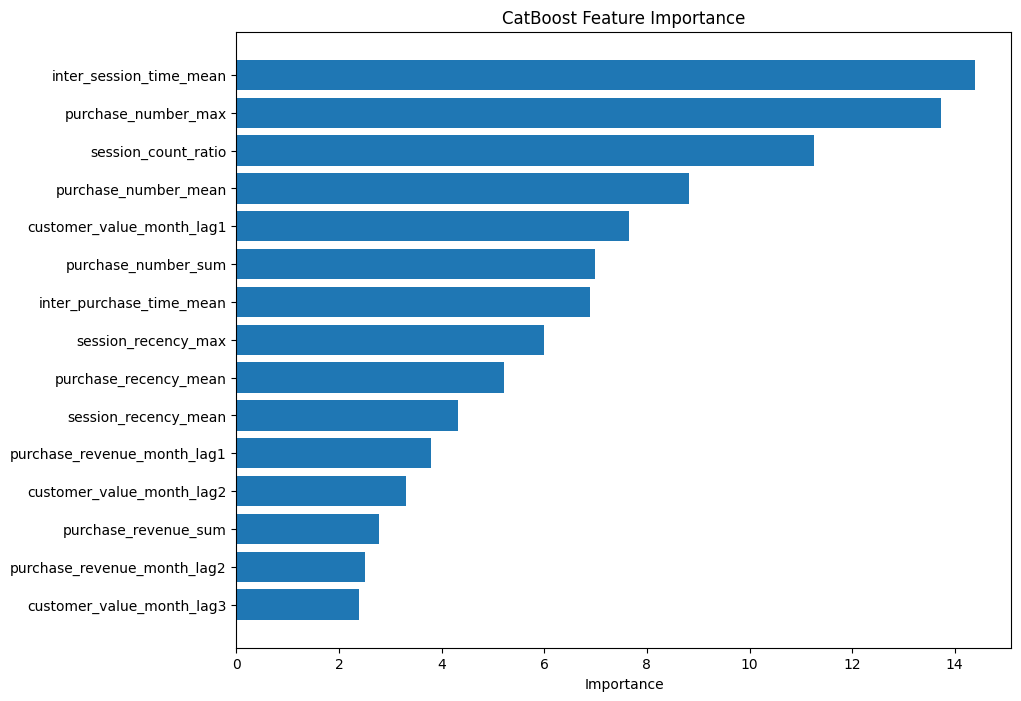


--- XGBoost Feature Importance ---
                        feature  importance
0           purchase_number_max    0.342556
3     customer_value_month_lag1    0.249156
11    customer_value_month_lag2    0.059205
1       inter_session_time_mean    0.041767
2           session_count_ratio    0.037601
9   purchase_revenue_month_lag1    0.034201
12    customer_value_month_lag3    0.032478
7         purchase_recency_mean    0.032019
5      inter_purchase_time_mean    0.031907
8           session_recency_max    0.031244
10         session_recency_mean    0.030537
6          purchase_number_mean    0.027961
13  purchase_revenue_month_lag2    0.025306
14         purchase_revenue_sum    0.024063
4           purchase_number_sum    0.000000


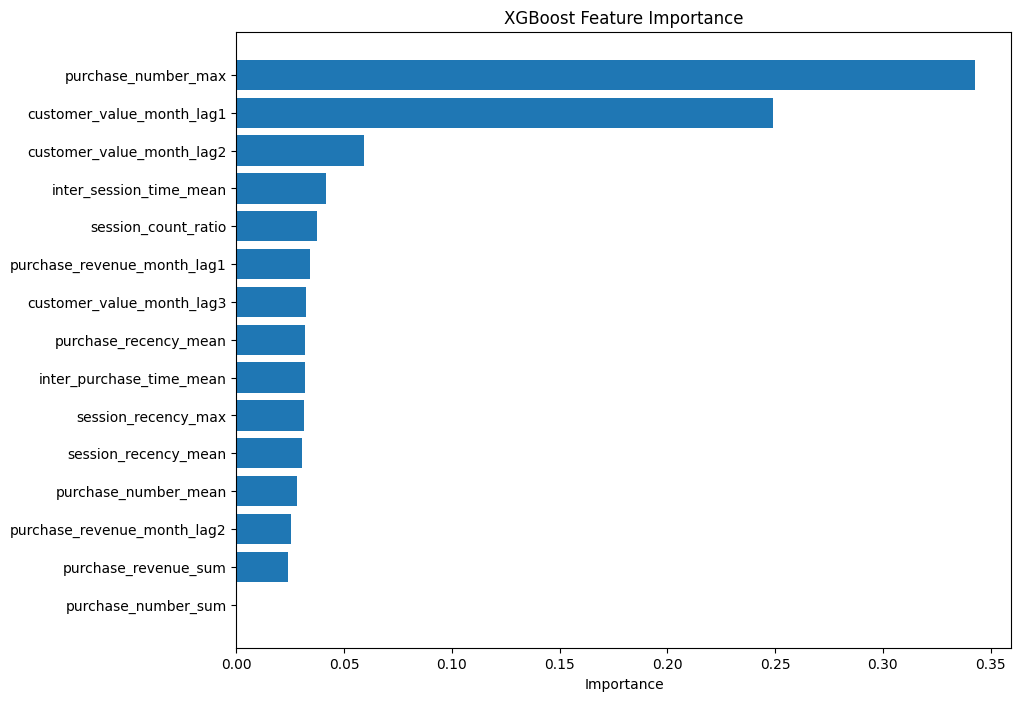


--- LightGBM Feature Importance ---
                        feature  importance
1       inter_session_time_mean        2085
2           session_count_ratio        1896
5      inter_purchase_time_mean        1541
8           session_recency_max        1470
0           purchase_number_max        1391
7         purchase_recency_mean        1289
14         purchase_revenue_sum        1178
10         session_recency_mean        1015
9   purchase_revenue_month_lag1         844
3     customer_value_month_lag1         823
13  purchase_revenue_month_lag2         788
12    customer_value_month_lag3         704
11    customer_value_month_lag2         662
4           purchase_number_sum           0
6          purchase_number_mean           0


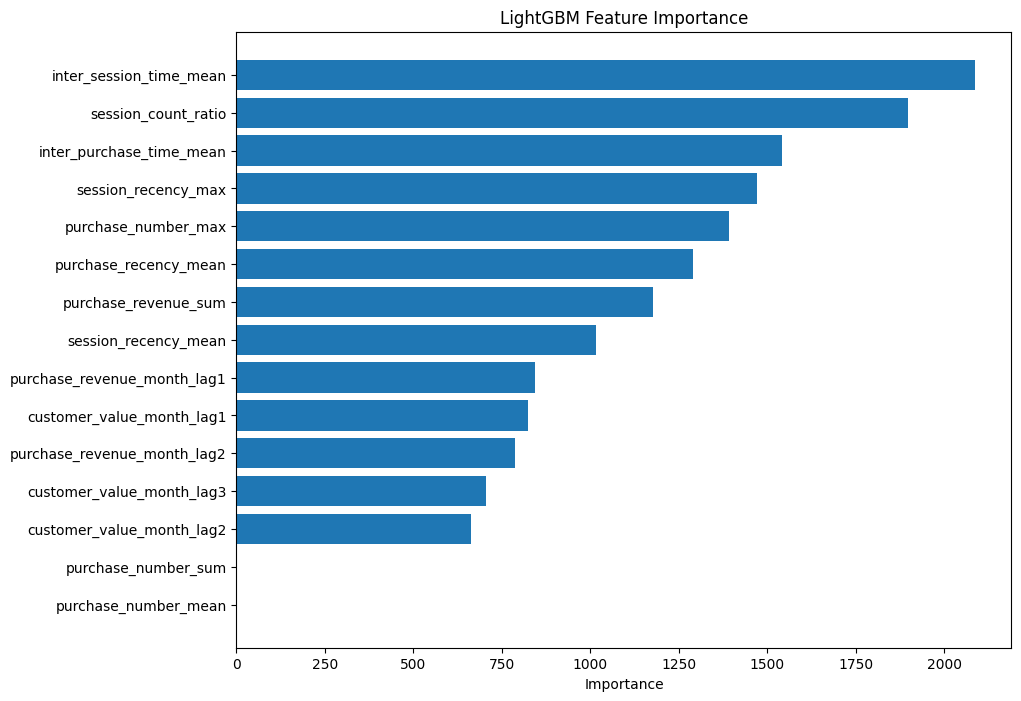

In [9]:
# -----------------------------
# Imports
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from lightgbm import LGBMClassifier

# -----------------------------
# Target and Features
# -----------------------------
# X, y are already defined from your selected features
# X = df[features], y = df['target_event']

# -----------------------------
# 1. CatBoost
# -----------------------------

cat_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_model.get_feature_importance(Pool(X, y))
}).sort_values(by='importance', ascending=False)

print("\n--- CatBoost Feature Importance ---")
print(cat_importance)

plt.figure(figsize=(10,8))
plt.barh(cat_importance['feature'], cat_importance['importance'])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

# -----------------------------
# 2. XGBoost
# -----------------------------


xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n--- XGBoost Feature Importance ---")
print(xgb_importance)

plt.figure(figsize=(10,8))
plt.barh(xgb_importance['feature'], xgb_importance['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

# -----------------------------
# 3. LightGBM
# -----------------------------
lgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n--- LightGBM Feature Importance ---")
print(lgb_importance)

plt.figure(figsize=(10,8))
plt.barh(lgb_importance['feature'], lgb_importance['importance'])
plt.gca().invert_yaxis()
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance")
plt.show()

# Model Evaluation (CatBoost/XGBoost/LightGBM)

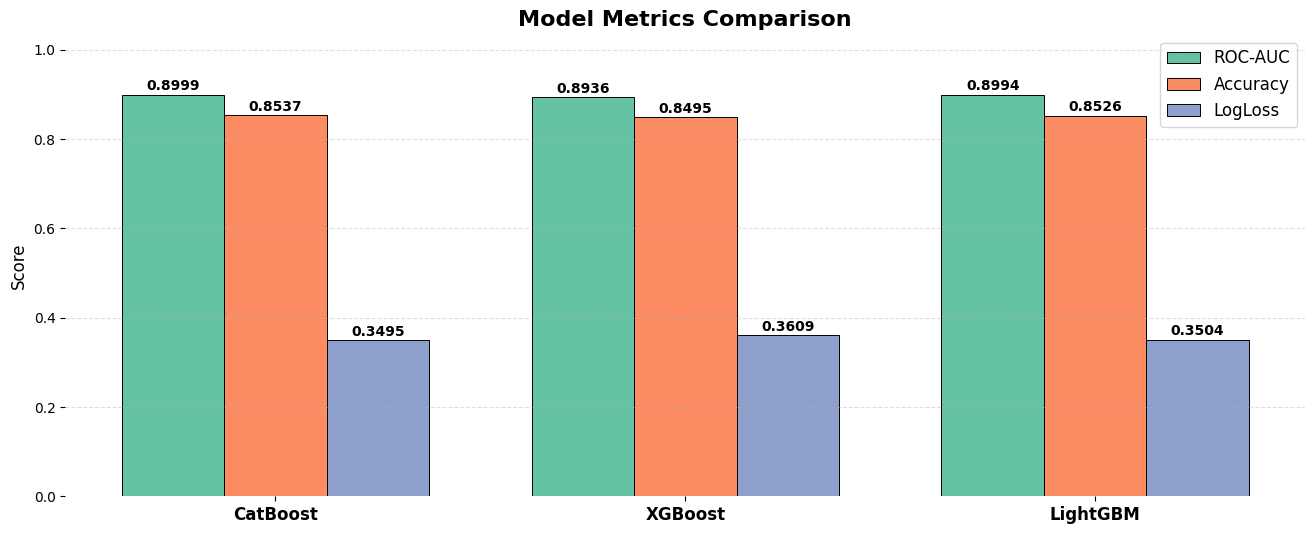

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

# Example: X_test, y_test = your test features and labels
models = {
    "CatBoost": cat_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}

# ------------------------
# Collect metrics dynamically
# ------------------------
metrics_list = []

for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    roc = roc_auc_score(y_test, y_pred_prob)
    acc = accuracy_score(y_test, y_pred)
    ll = log_loss(y_test, y_pred_prob)
    
    metrics_list.append({
        "Model": name,
        "ROC-AUC": roc,
        "Accuracy": acc,
        "LogLoss": ll
    })

# ------------------------
# Plot metrics comparison
# ------------------------
model_names = [m['Model'] for m in metrics_list]
roc_auc = [m['ROC-AUC'] for m in metrics_list]
accuracy = [m['Accuracy'] for m in metrics_list]
logloss = [m['LogLoss'] for m in metrics_list]

x = np.arange(len(model_names))
width = 0.25
colors = sns.color_palette("Set2", 3)

plt.figure(figsize=(16,6))
bars1 = plt.bar(x - width, roc_auc, width, label='ROC-AUC', color=colors[0], edgecolor='black', linewidth=0.7)
bars2 = plt.bar(x, accuracy, width, label='Accuracy', color=colors[1], edgecolor='black', linewidth=0.7)
bars3 = plt.bar(x + width, logloss, width, label='LogLoss', color=colors[2], edgecolor='black', linewidth=0.7)

plt.xticks(x, model_names, fontsize=12, fontweight='bold')
plt.ylabel("Score", fontsize=12)
plt.ylim(0, max(max(roc_auc), max(accuracy), max(logloss)) * 1.15)
plt.title("Model Metrics Comparison", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)

# Annotate bars with values
for i in range(len(model_names)):
    plt.text(i - width, roc_auc[i]+0.01, f"{roc_auc[i]:.4f}", ha='center', fontweight='bold')
    plt.text(i, accuracy[i]+0.01, f"{accuracy[i]:.4f}", ha='center', fontweight='bold')
    plt.text(i + width, logloss[i]+0.01, f"{logloss[i]:.4f}", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)
plt.show()


Business Impact Insight: Identify top churn drivers (e.g., long inter-purchase times, low cart activity) → actionable for retention campaigns.

# Visualizations

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


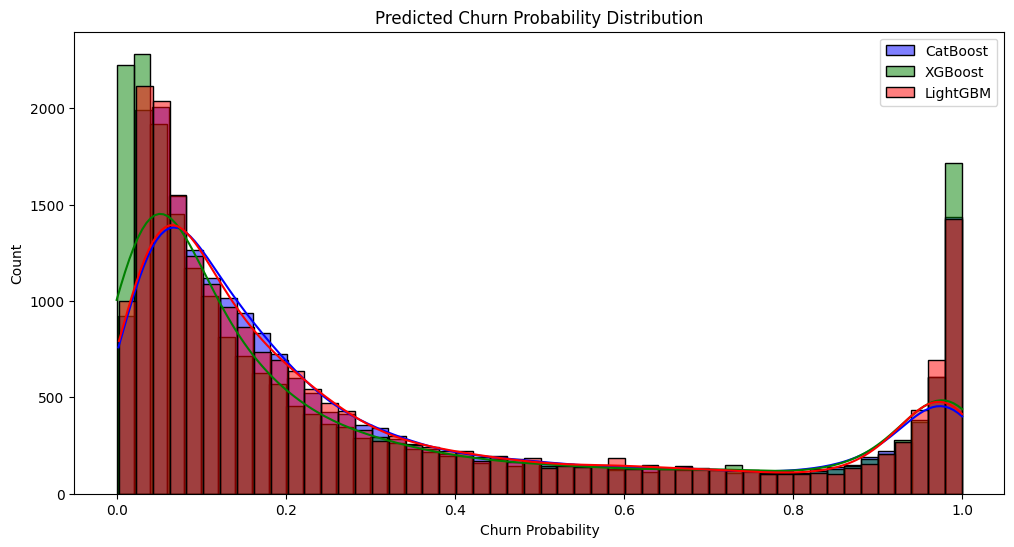

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# After fitting CatBoost
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]

# After fitting XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# After fitting LightGBM
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]


plt.figure(figsize=(12,6))
sns.histplot(y_prob_cat, bins=50, color='blue', kde=True, label='CatBoost', alpha=0.5)
sns.histplot(y_prob_xgb, bins=50, color='green', kde=True, label='XGBoost', alpha=0.5)
sns.histplot(y_prob_lgb, bins=50, color='red', kde=True, label='LightGBM', alpha=0.5)
plt.title("Predicted Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

> The histogram shows most users have low predicted churn probability, a smaller group has high probability, and the ensemble smooths the predictions across models.

LinkedIn Hook: “We found that customers with session gaps > 30 days are 3x more likely to churn.

# Confusion Matrix Display


--- CatBoost Confusion Matrix ---


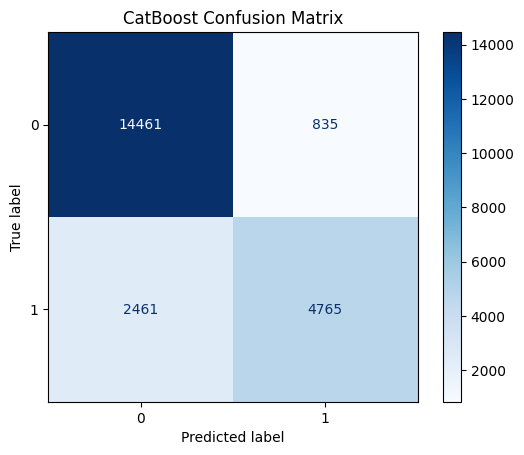


--- XGBoost Confusion Matrix ---


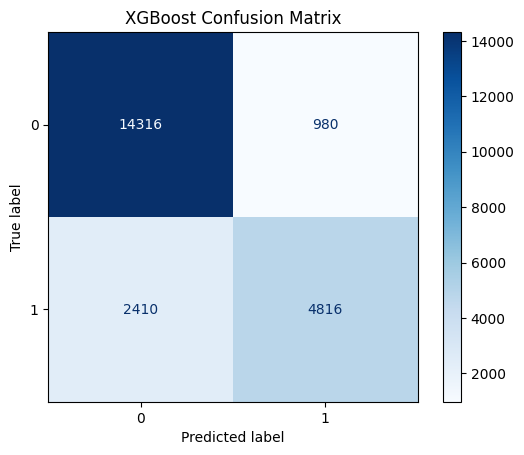


--- LightGBM Confusion Matrix ---


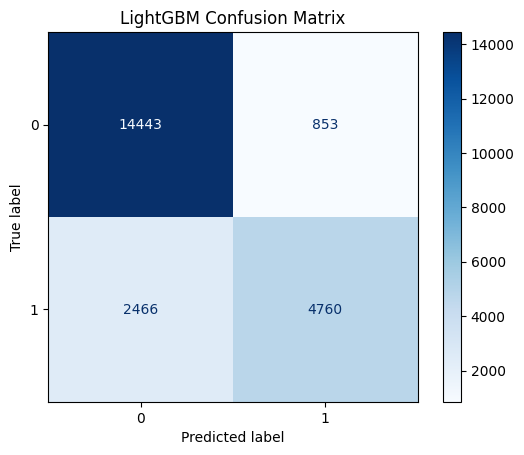

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model_cm(model, X_test, y_test, model_name="Model"):
    """
    Evaluate a trained model: Confusion matrix only.
    """
    print(f"\n--- {model_name} Confusion Matrix ---")
    
    # Predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)  # binary thresholding
    else:
        y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Usage
evaluate_model_cm(cat_model, X_test, y_test, "CatBoost")
evaluate_model_cm(xgb_model, X_test, y_test, "XGBoost")
evaluate_model_cm(lgb_model, X_test, y_test, "LightGBM")

# Deployment / Remote-Ready Packaging

In [13]:
import joblib

# ---------- Save CatBoost ----------
joblib.dump(cat_model, 'catboost_churn_model.pkl')
print("CatBoost model saved ✅")

# ---------- Save XGBoost ----------
joblib.dump(xgb_model, 'xgb_churn_model.pkl')
print("XGBoost model saved ✅")

# ---------- Save LightGBM ----------
joblib.dump(lgb_model, 'lgb_churn_model.pkl')
print("LightGBM model saved ✅")

CatBoost model saved ✅
XGBoost model saved ✅
LightGBM model saved ✅


In [14]:
import pandas as pd
import joblib
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb


# --------------------------
# Feature names (exactly as used in training)
# --------------------------
features = [
   'purchase_number_max','inter_session_time_mean','session_count_ratio',
    'customer_value_month_lag1','purchase_number_sum','inter_purchase_time_mean',
    'purchase_number_mean','purchase_recency_mean','session_recency_max',
    'purchase_revenue_month_lag1','session_recency_mean','customer_value_month_lag2',
    'customer_value_month_lag3','purchase_revenue_month_lag2','purchase_revenue_sum'
]

# --------------------------
# Demo customer data
# --------------------------
demo_data = {
    'purchase_number_max': 5,
    'inter_session_time_mean': 3.2,
    'session_count_ratio': 0.8,
    'customer_value_month_lag1': 120.0,
    'purchase_number_sum': 12,
    'inter_purchase_time_mean': 5.0,
    'purchase_number_mean': 2.5,
    'purchase_recency_mean': 15,
    'session_recency_max': 30,
    'purchase_revenue_month_lag1': 200.0,
    'session_recency_mean': 12,
    'customer_value_month_lag2': 110.0,
    'customer_value_month_lag3': 95.0,
    'purchase_revenue_month_lag2': 180.0,
    'purchase_revenue_sum': 700.0
}

demo_df = pd.DataFrame([demo_data])

# --------------------------
# Prepare DataFrames per model
# --------------------------
cat_df = demo_df.copy()            # CatBoost needs 'user_id'
other_df = demo_df[features]       # XGBoost & LightGBM without 'user_id'

# --------------------------
# Predict probabilities
# --------------------------
predictions = {}

# CatBoost
predictions['CatBoost'] = cat_model.predict_proba(cat_df)[:, 1][0]

# XGBoost
predictions['XGBoost'] = xgb_model.predict_proba(other_df)[:, 1][0]

# LightGBM
predictions['LightGBM'] = lgb_model.predict_proba(other_df)[:, 1][0]

# --------------------------
# Display results
# --------------------------
for model_name, prob in predictions.items():
    print(f"{model_name} Predicted Churn Probability: {prob:.4f}")


CatBoost Predicted Churn Probability: 0.0077
XGBoost Predicted Churn Probability: 0.1143
LightGBM Predicted Churn Probability: 0.0623
